In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt



In [9]:
sample_data = nc.Dataset("/Users/jianda/Projects/experience_replay_data/noer1117/replay_buffer_spinup5_seed1117_sample2_noprevQT_mix1.0_std_rbs0/nc_files/conv_mem_share3.cam.h0.1998-01-01-01800.nc")

In [10]:
sample_data.variables["QL"]

<class 'netCDF4._netCDF4.Variable'>
float32 QL(time, lev, lat, lon)
    mdims: 1
    units: g/g
    long_name: CRM-Input global grid water vapor
unlimited dimensions: time
current shape = (1, 30, 96, 144)
filling on, default _FillValue of 9.969209968386869e+36 used

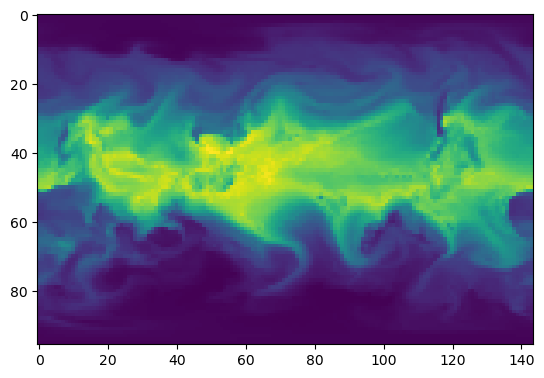

In [11]:
plt.imshow(sample_data.variables["QL"][0,28,:,:])